<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
## This notebook walks us through how to compute a tuning curve using the Allen Brain Observatory data


This notebook has two parts.  The first walks through computing a tuning curves for cells in response to a drifting grating stimulus. This is a classic single-cell analysis, and students can compare the tuning of several cells from the same experiment. The second part looks at correlations between cells that have the same tuning to the drifting grating stimulus from the same experiment. This highlights the fact that our dataset has populations of cells, simultaneously imaged, and allows for examinations of how those cells interact with each other.
This notebook is designed to only reference a single experiment from the Allen Brain Observatory, thus requires only one NWB file to be downloaded. (as downloading NWB files can be time consuming).

### Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import sys, os

### Brain Observatory set up

In [4]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
drive_path = '/data/allen-brain-observatory/visual-coding-2p'
manifest_file = os.path.join(drive_path,'manifest.json')
print(manifest_file)

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/allen-brain-observatory/visual-coding-2p/manifest.json


## Computing tuning curve for the drifting grating stimulus

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>We need:

<li>fluorescence trace for our cell.  We will use the DFF trace
<li>stimulus information for the drifting grating stimulus

</div>

In [5]:
cell_id = 541513979

First get the dataset for the session that this cell is in that has the drifting grating stimulus

In [6]:
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

Next get the dff trace for the chosen cell and the stimulus table

In [11]:
timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_id])
dff_trace = dff[0,:]
stim_table = data_set.get_stimulus_table('drifting_gratings')

In [12]:
dff.shape

(1, 115741)

# Point out get_dff_traces and cell indices as well as passing the cell_specimen_id

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
First let's plot the DF/F trace of our cell to see what it looks like
</div>

Text(0,0.5,'DFF')

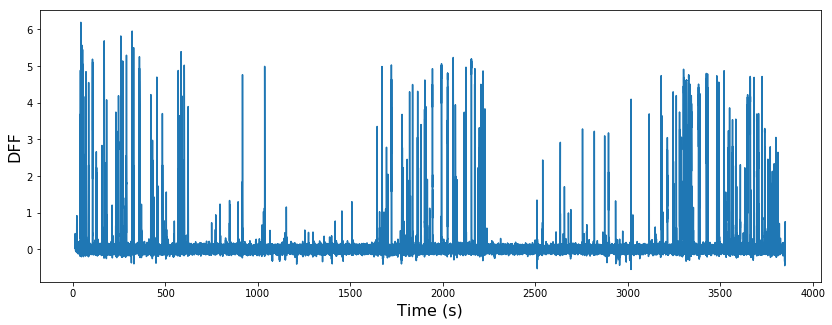

In [13]:
plt.figure(figsize=(14,5))
plt.plot(timestamps, dff_trace)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("DFF", fontsize=16)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Now let's look at our stimulus table to see what information we have. We just want to see the first few lines, so use the function <b>head</b> to see the top of this DataFrame.
</div>

In [14]:
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The stimulus table has 5 columns.  Start and end indicate the <b>frame number</b> when a given grating condition starts and ends, respectively. The other columns indicate what the grating codition is, including the temporal frequency of the grating (in Hz), the direction (called orientation) of the grating (in degrees), and whether the grating is a blank sweep (eg. a gray screen). 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Pandas is a very useful python module for data analysis, which has an object called a <b>DataFrame</b> that is a flexible and powerful tool for analyzing large datasets. I highly encourage interested students to explore this analysis module. But for our purposes, we will only use it to access the stimulus information. 
</div>

## Pandas

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">
<b>Quick pandas tutorial for our purposes today!</b>
<p>
To access data from a DataFrame we must specify the column we are using and specify the row using the <b>index</b>. To specify a column we can use two methods:
<li> stim_table['start']
<li> stim_table.start
<p> Then to specify the row we want we must use the index of that row. 
<li> stim_table['start'][0]
<li> stim_table.start[0]
<p> We can also subselect portions of the DataFrame using the values in the DataFrame. For example, to select only the rows of the table where the orientation is 90 degrees we can use:
<li> stim_table[stim_table.orientation==90]
<p>Try this yourself.  Note the index.  The rows of this subselected DataFrame maintain the indices of the original DataFrame. Now in order to get a specific row, you either need to know it's original index, or use <b>iloc</b>. For example, this will return the first row of the subselected DataFrame regardless of the original index of that row:
<li> stim_table[stim_table.orientation==90].iloc[0]
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
To look at the cell's response to a given grating presentation, let's plot the DF/F of the cell during the presentation of that grating.  We want to pad the plot with ~ 1 second of the DF/F trace preceding the grating presentation.  1 second = 30 frames.  We'll plot the response to the first grating presentation.
<div>

Text(0.5,0,'Frames')

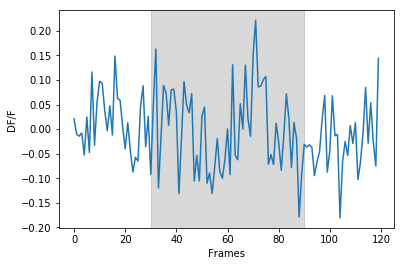

In [15]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

We want to quantify this response. We can explore different methods of quantifying this.
* mean DF/F during the grating presentation
* sum of the DF/F during the grating presentation (are these different?)
* maximum DF/F during grating

For now let's use the mean DF/F during the presentation of the grating.

In [16]:
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

-0.0020014683

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 1:** Repeat this for the next grating stimulus </div>

Text(0.5,0,'Frames')

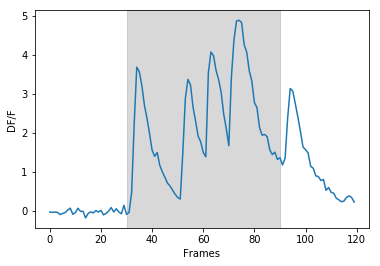

In [17]:
plt.plot(dff_trace[stim_table.start[1]-30:stim_table.end[1]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

In [18]:
dff_trace[stim_table.start[1]:stim_table.end[1]].mean()

2.292613

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
So already we can see that some stimulus conditions elicit larger responses than others.  This is what we want to quantify. 

<p><p>To do this, let's calculate the mean DF/F for each grating presentation in this stimulus. To start, let's create a numpy array to hold our calculated responses. We'll have three columns, one for the stimulus orientation, one for temporal frequency, and the last for the response. Then we need to iterate over all stimulus trials, populate the orientation and TF and then calculate the mean response.
</div>

In [19]:
cell_response= np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.orientation[i]
    cell_response[i,1] = stim_table.temporal_frequency[i]
    cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 3:** Compute the mean response as a function of orientation
<p> To start, you need to know what all the possible orientation values are. You can either find this from the website, or you can find the <b>unique</b> values that are not NaNs (eg. values that are <b>finite</b>)
</div>

In [23]:
all_ori = np.unique(cell_response[:,0])
orivals = all_ori[np.isfinite(all_ori)]
print orivals

[  0.  45.  90. 135. 180. 225. 270. 315.]


In [27]:
tfvals = np.unique(cell_response[:,1])
tfvals = tfvals[np.isfinite(tfvals)]
print tfvals

[ 1.  2.  4.  8. 15.]


<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 7:** Compute and plot the direction tuning curve separately for each of the 5 temporal frequencies. </div>

In [28]:
tuning_array = np.empty((8,5))
for i,tf in enumerate(tfvals):
    tf_trials = np.where(cell_response[:,1]==tf)[0]
    subset = cell_response[tf_trials]
    for j,ori in enumerate(orivals):
        trials = np.where(subset[:,0]==ori)
        tuning_array[j,i] = subset[trials,2].mean()        

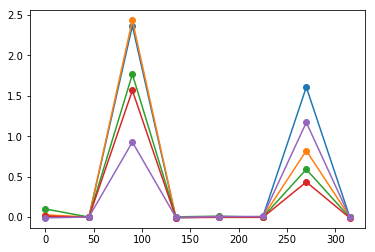

In [29]:
for i in range(5):
    plt.plot(orivals, tuning_array[:,i], 'o-')

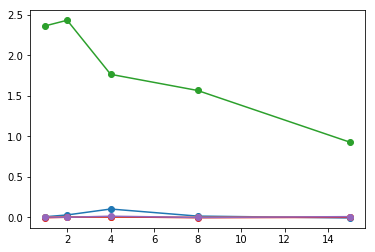

In [30]:
for i in range(5):
    plt.plot(tfvals, tuning_array[i,:], 'o-')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 8:** Are there other ways to visualize these tuning responses? </div>

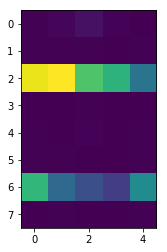

In [32]:
plt.imshow(tuning_array,)

We've computed the tuning for one neuron in this dataset. Now we want to compare this cell with the other cells in the dataset.  

How many cells are in the dataset?

In [33]:
timestamps, dff = data_set.get_dff_traces()

In [77]:
numbercells = dff.shape[0]
print numbercells

290


Compute the mean tuning response for each cell in the dataset. Write a function to create an array with dimensions (8,5,numbercells) with the mean response to each condition.

In [113]:
def compute_tuning_all_cells(dff, stim_table):
    numbercells = dff.shape[0]
    response = np.empty((8,5,numbercells))
    mean_sweep_response = pd.DataFrame(index=stim_table.index.values, columns=np.array(range(numbercells)).astype(str))
    for index, row in stim_table.iterrows():
        mean_sweep_response.loc[index] = dff[:,int(row.start):int(row.end)].mean(axis=1)
    for i,ori in enumerate(orivals):
        for j,tf in enumerate(tfvals):
            subset = mean_sweep_response[(stim_table.orientation==ori)&(stim_table.temporal_frequency==tf)]
            response[i,j,:] = subset.mean(axis=0).values
    return mean_sweep_response, response

In [114]:
msr, response = compute_tuning_all_cells(dff, stim_table)

Confirm your function by plotting the mean response for the cell that you used above.  Use data_set.get_cell_specimen_indices to find the index for that cell.

In [111]:
data_set.get_cell_specimen_indices(cell_specimen_ids=[cell_id])

[6]

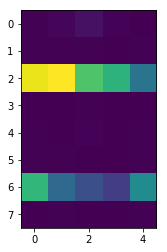

In [115]:
plt.imshow(response[:,:,6])

Compute the signal correlations (the correlation between mean responses) between all of the cells in your dataset.

In [116]:
import scipy.stats as st

In [148]:
signal_correlations = np.empty((numbercells, numbercells))
signal_correlations[:] = np.NaN
for i in range(numbercells):
    for j in range(numbercells):
        if j>i:
            r,p = st.pearsonr(response[:,:,i].flatten(), response[:,:,j].flatten())
            signal_correlations[i,j] = r

In [149]:
np.nanmean(signal_correlations)

0.25423116283754355

Report the mean signal correlation for your dataset using the google form.  Include the following metadata:
* which visual area is the data recorded in?
* which Cre line is it from?
* at what imaging depth was the data collected
* what is the age (in days) of the mouse when the data was collected?
* how many neurons were imaged?



In [120]:
data_set.get_metadata()

{'age_days': 121,
 'cre_line': u'Emx1-IRES-Cre/wt',
 'device': u'Nikon A1R-MP multiphoton microscope',
 'device_name': u'CAM2P.1',
 'excitation_lambda': u'910 nanometers',
 'experiment_container_id': 536323956,
 'fov': u'400x400 microns (512 x 512 pixels)',
 'genotype': u'Emx1-IRES-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth_um': 175,
 'indicator': u'GCaMP6f',
 'ophys_experiment_id': 540684467,
 'pipeline_version': u'3.0',
 'session_start_time': datetime.datetime(2016, 8, 23, 11, 45, 14),
 'session_type': u'three_session_A',
 'sex': u'male',
 'specimen_name': u'Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174',
 'targeted_structure': u'VISp'}

Drifting gratings isn't the only stimulus presented during this session. Find what other stimuli were presented.

In [121]:
data_set.get_stimulus_epoch_table()

,stimulus,start,end
0,drifting_gratings,736,18810
1,natural_movie_three,19746,37850
2,natural_movie_one,38756,47807
3,drifting_gratings,48712,66786
4,spontaneous,66936,75868
5,natural_movie_three,75869,93972
6,drifting_gratings,94878,115485


Let's compare the signal correlations of the responses to drifting gratings to those for natural movie three.

The dff traces we have are for the entire session, so we already have that. But we need the stimulus table for the natural movie.

In [122]:
stim_table_nm3 = data_set.get_stimulus_table('natural_movie_three')

In [123]:
stim_table_nm3.head()

,frame,start,end,repeat
0,0,19746,19747,0
1,1,19747,19748,0
2,2,19748,19749,0
3,3,19749,19750,0
4,4,19750,19751,0


How many frames are in the natural movie? How many repeats? How long does each frame (typically) last? (why might it vary from this?) 

In [125]:
len(stim_table_nm3.frame.unique())

3600

In [126]:
len(stim_table_nm3.repeat.unique())

10

And for completeness, let's look at the first and the last frame of the movie

In [127]:
template = data_set.get_stimulus_template('natural_movie_three')

In [128]:
template.shape

(3600, 304, 608)

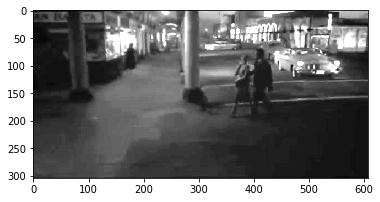

In [129]:
plt.imshow(template[0,:,:], cmap='gray')

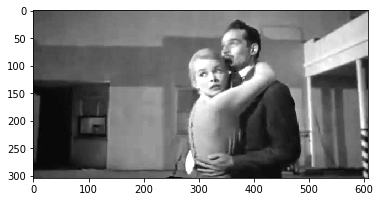

In [130]:
plt.imshow(template[-1,:,:], cmap='gray')

Smooch smooch BOOM!

Compute the mean response for each neuron to the movie.  

In [133]:
response_nm3 = np.empty((numbercells, 3600))
temp = np.empty((numbercells, 3600, 10))
for i in range(10):
    start_time = int(stim_table_nm3[(stim_table_nm3.frame==0)&(stim_table_nm3.repeat==i)].start)
    temp[:,:,i] = dff[:, start_time:start_time+3600]
response_nm3 = temp.mean(axis=2)

Plot the mean movie response for the cell you analyzed above

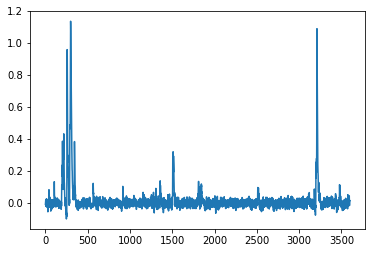

In [134]:
plt.plot(response_nm3[6,:])

Compute the correlation of mean movie response for all neurons

In [150]:
movie_correlations = np.empty((numbercells, numbercells))
movie_correlations[:] = np.NaN
for i in range(numbercells):
    for j in range(numbercells):
        if j>i:
            r,p = st.pearsonr(response_nm3[i,:], response_nm3[j,:])
            movie_correlations[i,j] = r

In [151]:
np.nanmean(movie_correlations)

0.07977039598639278

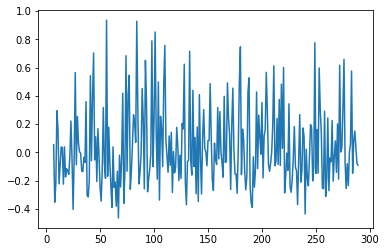

In [152]:
plt.plot(signal_correlations[6,:])

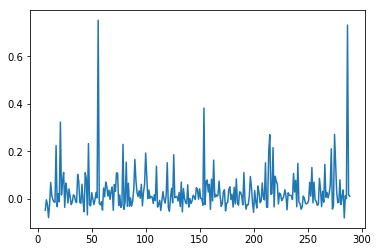

In [153]:
plt.plot(movie_correlations[6,:])

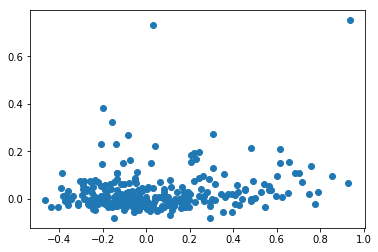

In [155]:
plt.plot(signal_correlations[6,:], movie_correlations[6,:], 'o')